In [1]:
# Runtime -> Change runtime type -> GPU (T4/A100 OK)
import torch, os, sys, subprocess, pathlib
print("CUDA:", torch.cuda.is_available(), torch.version.cuda)
from google.colab import drive
drive.mount('/content/drive')
ROOT = pathlib.Path('/content')
GDRIVE = pathlib.Path('/content/drive/MyDrive')

CUDA: True 12.6
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%pwd

'/content'

In [3]:
import pathlib
from huggingface_hub import login

# Path to your HF token file
HF_TOKEN_PATH = GDRIVE / "DOODL-experiments" / "HFToken.txt"

# Read the token from the file
try:
    with open(HF_TOKEN_PATH, "r") as f:
        hf_token = f.read().strip()
    login(hf_token) # Login with the token read from file
    print("Successfully logged into Hugging Face Hub using token from file.")
except FileNotFoundError:
    print(f"Error: HFToken.txt not found at {HF_TOKEN_PATH}. Please create the file with your token.")
except Exception as e:
    print(f"An error occurred while logging into Hugging Face Hub: {e}")


Successfully logged into Hugging Face Hub using token from file.


In [4]:
%pip install -q "transformers>=4.44.0" "tokenizers>=0.19.0" ftfy regex safetensors
%pip install -q open-clip-torch lpips einops

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 6.0 MB/s eta 0:00:00


In [5]:
# Minimal setup for your fork + HF auth
%cd /content
!rm -rf DOODL
!git clone --depth 1 -b mechint https://github.com/cem1234/DOODL.git
%cd DOODL

# HF login and write token to the file DOODL expects
%pip -q install huggingface_hub
from huggingface_hub import login, HfFolder
login()  # paste your token (hf_...) when prompted
from pathlib import Path
tok = HfFolder.get_token()
Path("hf_auth").write_text(tok + "\n")  # single line, no quotes

# (Optional) install your Colab deps if the file exists
if Path("requirements-colab.txt").exists():
    %pip -q install -r requirements-colab.txt

/content
Cloning into 'DOODL'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 157 (delta 12), reused 151 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (157/157), 3.40 MiB | 41.94 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/DOODL


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
# Import DOODL from your fork
import sys, pathlib
sys.path.insert(0, str(pathlib.Path.cwd()))
assert "custom_mechint" in pathlib.Path("doodl.py").read_text()
import doodl
print("DOODL ready ✅")

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/1.72G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

Loaded all models
Using torch float16, if need more precision need to change custom_fwd


/content/DOODL/memcnn/models/revop.py:24: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @custom_fwd(cast_inputs=torch.float16)
/content/DOODL/memcnn/models/revop.py:80: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  @custom_bwd


DOODL ready ✅


In [37]:
import json, subprocess, datetime, os

# --- Define experiment naming ---
source_class = "sports car"
target_class = "pickup"

ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"{source_class}2{target_class}_{ts}"
RUNS_ROOT = Path("/content/drive/MyDrive/DOODL-experiments/Runs")
run_dir = RUNS_ROOT / run_name
run_dir.mkdir(parents=True, exist_ok=True)

In [38]:
run_dir

PosixPath('/content/drive/MyDrive/DOODL-experiments/Runs/sports car2pickup_20251202_022259')

In [39]:
import torchvision, pkgutil, sys
print("torch:", torch.__version__, "torchvision:", torchvision.__version__,
      "CUDA available?", torch.cuda.is_available(), "py", sys.version)

# compiled ops sanity check
from torchvision.ops import nms
print("torchvision.ops.nms OK")

# DOODL uses its own diffusers; just ensure the vendored package is discoverable
import pathlib, sys
sys.path.insert(0, str(pathlib.Path("/content/DOODL").resolve()))
assert pkgutil.find_loader("my_half_diffusers") is not None, "Local my_half_diffusers not found"
print("Local my_half_diffusers is importable ✔️")

torch: 2.9.0+cu126 torchvision: 0.24.0+cu126 CUDA available? True py 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
torchvision.ops.nms OK
Local my_half_diffusers is importable ✔️


/tmp/ipython-input-993846761.py:12: DeprecationWarning: 'pkgutil.find_loader' is deprecated and slated for removal in Python 3.14; use importlib.util.find_spec() instead
  assert pkgutil.find_loader("my_half_diffusers") is not None, "Local my_half_diffusers not found"


In [40]:
# Example: /content/drive/MyDrive/MI-experiments (edit to yours)
MI_CODE_DIR = GDRIVE/"DOODL-experiments"
assert MI_CODE_DIR.exists(), f"Update MI_CODE_DIR; not found: {MI_CODE_DIR}"
import sys
sys.path.append(str(MI_CODE_DIR))

In [41]:
# Point to where your probe results live
PROBE_ROOT = GDRIVE/"ViT_MI"/"Bcos Results Minimal Probe"     # edit to your path
assert PROBE_ROOT.exists(), "Update PROBE_ROOT to your probe directory"

# A reference image you want to keep close to (for LPIPS and/or inversion anchor)
img_name = "imagenet_"+source_class+"/040900.jpg"
REF_IMAGE = GDRIVE/"ViT_MI"/"Images"/img_name  # edit to your path
assert REF_IMAGE.exists(), "Update REF_IMAGE to your reference image"

In [42]:
%pwd

'/content/DOODL'

Import bcos and build masked model

In [17]:
!pip install --quiet bcos

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.5 MB/s eta 0:00:00


In [18]:
import bcos
import utils as ut
from bcos.data.categories import IMAGENET_CATEGORIES
from env_loader import ProbeResultsRepository
from space import (
    Subspace,
    build_subspace_from_probe,
    project_activations,
    probe_to_vector,
)

import argparse
import json
from dataclasses import asdict, dataclass
from datetime import datetime
from pathlib import Path

In [19]:
def load_env(model_name: str = "bcos"):
    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

    if model_name == "gelu":
        model = bcos.pretrained.standard_vitc_ti_patch1_14(pretrained=True)
        layer_names = [f"transformer.encoder_{i}" for i in range(11)]
    elif model_name == "bcos":
        model = bcos.pretrained.vitc_ti_patch1_14(pretrained=True)
        layer_names = [f"0.transformer.encoder_{i}" for i in range(11)]
    else:
        raise ValueError(f"Invalid model name: {model_name}")

    model.to(device)
    model.eval()

    masked_model_modal = ut.MaskedModelModal(model, layer_names, 192, mask_ON=False, device=device)
    masked_model_modal.to(device)
    masked_model_modal.eval()

    idx2label: Sequence[str] = list(IMAGENET_CATEGORIES)
    return device, model, masked_model_modal, idx2label

In [20]:
from torchvision.transforms.functional import InterpolationMode
def preprocess_bcos_tensor(
    tensor: torch.Tensor,
    *,
    data_range: tuple[float, float],
    resize_size: int = 256,
    crop_size: int = 224,
) -> torch.Tensor:
    tensor = tensor.to(dtype=torch.float32)
    if tensor.ndim == 3:
        tensor = tensor.unsqueeze(0)
    lo, hi = data_range
    tensor = (tensor - lo) / (hi - lo + 1e-8)
    tensor = tensor.clamp(0.0, 1.0)
    tensor = TF.resize(tensor, resize_size, interpolation=InterpolationMode.BILINEAR, antialias=True)
    tensor = TF.center_crop(tensor, crop_size)
    inverse = 1.0 - tensor
    return torch.cat([tensor, inverse], dim=1)

Wiring your models & probes, and running DOODL with your loss

In [43]:
device, model, masked_model_modal, idx2label = load_env(model_name="bcos")

# Load probe & subspace
from pathlib import Path

repo = ProbeResultsRepository(root=str(PROBE_ROOT))
runs = repo.sorted_probes(target_class, by="nonzero", ascending=True, return_records=True)
assert runs, f"No probes found for target class '{target_class}'"
probe_record = runs[0]
probe = probe_record.probe
subspace = build_subspace_from_probe(probe)

# Build unit_probe
probe_vec = probe_to_vector(probe.to(device), subspace).to(device)
probe_norm = torch.norm(probe_vec)
assert probe_norm.item() > 0, "Probe vector has zero norm"
unit_probe = probe_vec / probe_norm

# Target index for CE
target_idx = idx2label.index(target_class)

In [44]:
from PIL import Image
import torchvision.transforms.functional as TF
import torch
import lpips

# Load reference image and convert to the **VAE decode range** [-1, 1]
ref_pil = Image.open(str(REF_IMAGE)).convert("RGB")
ref_tensor_01 = TF.to_tensor(ref_pil).unsqueeze(0).to(device)    # [0,1]
ref_tensor_m11 = ref_tensor_01 * 2.0 - 1.0                       # [-1,1]

# LPIPS (VGG backbone expects [-1,1])
lpips_model = lpips.LPIPS(net='vgg').to(device).eval()

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/vgg.pth


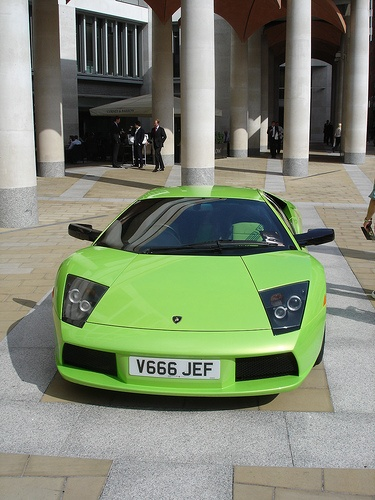

In [45]:
ref_pil

In [46]:
# Make sure your BCos env + probe utilities are loaded already:
# device, masked_model_modal, idx2label, project_activations, subspace, unit_probe, preprocess_bcos_tensor, etc.

# If you want LPIPS relative to a reference *tensor* you already have:
# ref_tensor_m11 must be in [-1, 1], shape (1,3,H,W)
# Otherwise you can pass a ref image path in Cell 11.

model_guidance_type = "custom_mechint"
model_guidance_dict = {
    'masked_model_modal': masked_model_modal,      # your BCos wrapper
    'target_idx': target_idx,
    'project_activations': project_activations,
    'subspace': subspace,
    'unit_probe': unit_probe,                      # normalized probe vector
    'probe_raw': probe_vec,             # << NEW: unnormalized probe
    'preprocess_to_bcos': preprocess_bcos_tensor,  # your preprocessing fn
    'lpips_model': lpips_model,
    # Either provide a ref tensor in [-1,1] here...
    # 'ref_tensor_m11': ref_tensor_m11,
    # ...or pass 'ref_image_path' in the next cell.
    'token_agg': 'cls',
    # weights for CE / probe / LPIPS components of the pixel-space loss:
    'weights': {'ce': 1.0, 'probe': 0.0, 'lpips': 10.0, 'z_l2': 1.0},  # << add z_l2 weight
    # latent-prior anti-drift (acts on trainable latents; added inside traversal loop)
    'latent_prior_weight': 0.0,
    'latent_sigma': 1.0,
    # 'z_l2_squared': True,  # optional toggle; default True
}

A) Image editing (optimize around a source image)

⚠️ In the repo code, editing (source_im not None) asserts renormalize_latents must be False. Also, for LPIPS anti-drift, pass the same image as ref_image_path (or set ref_tensor_m11 in Cell 10).

In [47]:
# If you prefer LPIPS vs the source image path:
model_guidance_dict_with_ref = dict(model_guidance_dict, **{
    'ref_image_path': str(REF_IMAGE)
})

# --- Build experiment config dict (what you pass to doodl.gen) ---
save_str = "gen_img.png"

exp_cfg = dict(
    cond_prompt="",
    model_guidance_type=model_guidance_type,
    model_guidance_dict=model_guidance_dict_with_ref,  # defined earlier in your notebook
    save_str=save_str,
    save_dir=str(run_dir),            # <— the key bit: persist to Drive
    grad_scale=0.1,
    clip_grad_val=1e-2,               # e.g., 1e-2
    sd_guidance_scale=7.5,
    latent_traversal=True,
    num_traversal_steps=60,
    steps=50,
    mix_weight=0.93,
    use_cutouts=True, num_cuts=16, cut_power=0.3,
    tied_latents=True,
    use_momentum=True,
    perturb_grad_scale=1e-4,
    opt_t=None,
    renormalize_latents=False,        # FALSE when starting with reference image
    source_im=str(REF_IMAGE),         # triggers inversion → latent anchor
)

# --- Save a run manifest for later reference (no tensors/models) ---
manifest = {
    "run_name": run_name,
    "timestamp": ts,
    "source_class": source_class,
    "target_class": target_class,
    # Only include JSON-serializable fields from exp_cfg (avoid tensors/models)
    "exp_cfg": {
        k: v for k, v in exp_cfg.items()
        if isinstance(v, (str, int, float, bool, type(None)))
        or k in ("save_dir", "save_str")  # keep paths
    },
    # pull the simple weights if present
    "weights": getattr(exp_cfg.get("model_guidance_dict", {}), "get", lambda *_: None)("weights"),
}
(run_dir / "run_config.json").write_text(json.dumps(manifest, indent=2))

# --- Run the experiment: all images + CSV logs will land in run_dir ---
print("Run directory:", run_dir)
doodl.gen(**exp_cfg)
print("✅ Done. Outputs saved under:", run_dir)

Run directory: /content/drive/MyDrive/DOODL-experiments/Runs/sports car2pickup_20251202_022259


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Optimization Step 0


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


[step 0000] raw:     CE=6.698e+00  align=1.621e+00  LPIPS=1.188e-01  zL2=1.095e+01  prior=0.000e+00  prob=0.001  total=3.770e+00
           contrib: w*CE=6.698e+00  w*probe=-0.000e+00  w*LPIPS=1.188e+00  w*prior=0.000e+00  w*zL2=1.095e+01  total=1.884e+01
             norms: z0=2.177e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=5.171e-01  ||g||_clip=4.077e-01  max|g|=7.086e-02
Optimization Step 1


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


Optimization Step 2


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


[step 0002] raw:     CE=7.327e+00  align=1.670e+00  LPIPS=5.566e-01  zL2=1.109e+01  prior=0.000e+00  prob=0.001  total=4.791e+00
           contrib: w*CE=7.327e+00  w*probe=-0.000e+00  w*LPIPS=5.566e+00  w*prior=0.000e+00  w*zL2=1.109e+01  total=2.398e+01
             norms: z0=2.095e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=3.665e-01  ||g||_clip=3.235e-01  max|g|=3.705e-02
Optimization Step 3


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


Optimization Step 4


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


[step 0004] raw:     CE=7.255e+00  align=1.688e+00  LPIPS=5.413e-01  zL2=1.089e+01  prior=0.000e+00  prob=0.001  total=4.707e+00
           contrib: w*CE=7.255e+00  w*probe=-0.000e+00  w*LPIPS=5.413e+00  w*prior=0.000e+00  w*zL2=1.089e+01  total=2.355e+01
             norms: z0=2.113e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=4.895e-01  ||g||_clip=4.294e-01  max|g|=7.141e-02
Optimization Step 5


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Optimization Step 6


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


[step 0006] raw:     CE=7.049e+00  align=1.902e+00  LPIPS=5.645e-01  zL2=9.743e+00  prior=0.000e+00  prob=0.001  total=4.485e+00
           contrib: w*CE=7.049e+00  w*probe=-0.000e+00  w*LPIPS=5.645e+00  w*prior=0.000e+00  w*zL2=9.743e+00  total=2.244e+01
             norms: z0=2.234e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=2.988e-01  ||g||_clip=2.903e-01  max|g|=2.011e-02
Optimization Step 7


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Optimization Step 8


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


[step 0008] raw:     CE=6.939e+00  align=1.864e+00  LPIPS=5.662e-01  zL2=9.895e+00  prior=0.000e+00  prob=0.001  total=4.499e+00
           contrib: w*CE=6.939e+00  w*probe=-0.000e+00  w*LPIPS=5.662e+00  w*prior=0.000e+00  w*zL2=9.895e+00  total=2.250e+01
             norms: z0=2.215e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=2.827e-01  ||g||_clip=2.754e-01  max|g|=1.968e-02
Optimization Step 9


100%|██████████| 50/50 [00:09<00:00,  5.23it/s]


Optimization Step 10


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


[step 0010] raw:     CE=6.547e+00  align=2.002e+00  LPIPS=5.570e-01  zL2=9.237e+00  prior=0.000e+00  prob=0.001  total=4.265e+00
           contrib: w*CE=6.547e+00  w*probe=-0.000e+00  w*LPIPS=5.570e+00  w*prior=0.000e+00  w*zL2=9.237e+00  total=2.135e+01
             norms: z0=2.349e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=3.789e-01  ||g||_clip=3.528e-01  max|g|=3.192e-02
Optimization Step 11


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Optimization Step 12


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


[step 0012] raw:     CE=6.359e+00  align=1.954e+00  LPIPS=5.179e-01  zL2=9.342e+00  prior=0.000e+00  prob=0.002  total=4.175e+00
           contrib: w*CE=6.359e+00  w*probe=-0.000e+00  w*LPIPS=5.179e+00  w*prior=0.000e+00  w*zL2=9.342e+00  total=2.088e+01
             norms: z0=2.357e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=2.812e-01  ||g||_clip=2.744e-01  max|g|=2.089e-02
Optimization Step 13


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


Optimization Step 14


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


[step 0014] raw:     CE=5.661e+00  align=2.164e+00  LPIPS=5.671e-01  zL2=8.625e+00  prior=0.000e+00  prob=0.003  total=3.995e+00
           contrib: w*CE=5.661e+00  w*probe=-0.000e+00  w*LPIPS=5.671e+00  w*prior=0.000e+00  w*zL2=8.625e+00  total=1.996e+01
             norms: z0=2.554e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=3.628e-01  ||g||_clip=3.457e-01  max|g|=2.774e-02
Optimization Step 15


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


Optimization Step 16


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


[step 0016] raw:     CE=3.074e+00  align=2.288e+00  LPIPS=5.789e-01  zL2=8.410e+00  prior=0.000e+00  prob=0.046  total=3.464e+00
           contrib: w*CE=3.074e+00  w*probe=-0.000e+00  w*LPIPS=5.789e+00  w*prior=0.000e+00  w*zL2=8.410e+00  total=1.727e+01
             norms: z0=2.714e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=2.742e+00  ||g||_clip=1.144e+00  max|g|=2.367e-01
Optimization Step 17


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Optimization Step 18


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


[step 0018] raw:     CE=3.437e+00  align=2.293e+00  LPIPS=5.437e-01  zL2=8.310e+00  prior=0.000e+00  prob=0.032  total=3.435e+00
           contrib: w*CE=3.437e+00  w*probe=-0.000e+00  w*LPIPS=5.437e+00  w*prior=0.000e+00  w*zL2=8.310e+00  total=1.718e+01
             norms: z0=2.748e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=4.741e-01  ||g||_clip=4.280e-01  max|g|=4.230e-02
Optimization Step 19


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Optimization Step 20


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


[step 0020] raw:     CE=2.491e+00  align=2.105e+00  LPIPS=5.822e-01  zL2=8.712e+00  prior=0.000e+00  prob=0.083  total=3.417e+00
           contrib: w*CE=2.491e+00  w*probe=-0.000e+00  w*LPIPS=5.822e+00  w*prior=0.000e+00  w*zL2=8.712e+00  total=1.702e+01
             norms: z0=2.505e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=5.176e+00  ||g||_clip=1.322e+00  max|g|=5.479e-01
Optimization Step 21


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Optimization Step 22


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


[step 0022] raw:     CE=5.393e+00  align=2.028e+00  LPIPS=5.979e-01  zL2=8.996e+00  prior=0.000e+00  prob=0.005  total=4.071e+00
           contrib: w*CE=5.393e+00  w*probe=-0.000e+00  w*LPIPS=5.979e+00  w*prior=0.000e+00  w*zL2=8.996e+00  total=2.037e+01
             norms: z0=2.433e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=5.830e-01  ||g||_clip=5.117e-01  max|g|=6.696e-02
Optimization Step 23


100%|██████████| 50/50 [00:09<00:00,  5.23it/s]


Optimization Step 24


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


[step 0024] raw:     CE=5.549e+00  align=2.051e+00  LPIPS=6.062e-01  zL2=9.001e+00  prior=0.000e+00  prob=0.004  total=4.113e+00
           contrib: w*CE=5.549e+00  w*probe=-0.000e+00  w*LPIPS=6.062e+00  w*prior=0.000e+00  w*zL2=9.001e+00  total=2.061e+01
             norms: z0=2.493e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=4.761e-01  ||g||_clip=4.368e-01  max|g|=3.369e-02
Optimization Step 25


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


Optimization Step 26


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


[step 0026] raw:     CE=3.560e+00  align=2.208e+00  LPIPS=6.068e-01  zL2=8.564e+00  prior=0.000e+00  prob=0.028  total=3.645e+00
           contrib: w*CE=3.560e+00  w*probe=-0.000e+00  w*LPIPS=6.068e+00  w*prior=0.000e+00  w*zL2=8.564e+00  total=1.819e+01
             norms: z0=2.676e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=8.418e-01  ||g||_clip=5.688e-01  max|g|=1.011e-01
Optimization Step 27


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Optimization Step 28


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


[step 0028] raw:     CE=1.503e+00  align=2.131e+00  LPIPS=5.884e-01  zL2=8.627e+00  prior=0.000e+00  prob=0.223  total=3.212e+00
           contrib: w*CE=1.503e+00  w*probe=-0.000e+00  w*LPIPS=5.884e+00  w*prior=0.000e+00  w*zL2=8.627e+00  total=1.601e+01
             norms: z0=2.558e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=5.757e-01  ||g||_clip=4.927e-01  max|g|=4.065e-02
Optimization Step 29


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Optimization Step 30


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


[step 0030] raw:     CE=8.495e-01  align=2.102e+00  LPIPS=5.901e-01  zL2=8.722e+00  prior=0.000e+00  prob=0.428  total=3.104e+00
           contrib: w*CE=8.495e-01  w*probe=-0.000e+00  w*LPIPS=5.901e+00  w*prior=0.000e+00  w*zL2=8.722e+00  total=1.547e+01
             norms: z0=2.538e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=4.932e-01  ||g||_clip=4.287e-01  max|g|=4.056e-02
Optimization Step 31


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


Optimization Step 32


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


[step 0032] raw:     CE=3.488e-01  align=2.179e+00  LPIPS=5.913e-01  zL2=8.371e+00  prior=0.000e+00  prob=0.706  total=2.933e+00
           contrib: w*CE=3.488e-01  w*probe=-0.000e+00  w*LPIPS=5.913e+00  w*prior=0.000e+00  w*zL2=8.371e+00  total=1.463e+01
             norms: z0=2.615e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=2.350e-01  ||g||_clip=2.195e-01  max|g|=2.287e-02
Optimization Step 33


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


Optimization Step 34


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


[step 0034] raw:     CE=2.521e-01  align=2.210e+00  LPIPS=5.921e-01  zL2=8.101e+00  prior=0.000e+00  prob=0.777  total=2.862e+00
           contrib: w*CE=2.521e-01  w*probe=-0.000e+00  w*LPIPS=5.921e+00  w*prior=0.000e+00  w*zL2=8.101e+00  total=1.427e+01
             norms: z0=2.655e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=7.510e-01  ||g||_clip=4.897e-01  max|g|=1.445e-01
Optimization Step 35


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Optimization Step 36


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


[step 0036] raw:     CE=3.551e-01  align=2.171e+00  LPIPS=5.900e-01  zL2=8.109e+00  prior=0.000e+00  prob=0.701  total=2.874e+00
           contrib: w*CE=3.551e-01  w*probe=-0.000e+00  w*LPIPS=5.900e+00  w*prior=0.000e+00  w*zL2=8.109e+00  total=1.436e+01
             norms: z0=2.624e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=3.003e-01  ||g||_clip=2.610e-01  max|g|=3.870e-02
Optimization Step 37


100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Optimization Step 38


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


[step 0038] raw:     CE=6.983e-01  align=2.193e+00  LPIPS=6.030e-01  zL2=7.942e+00  prior=0.000e+00  prob=0.497  total=2.937e+00
           contrib: w*CE=6.983e-01  w*probe=-0.000e+00  w*LPIPS=6.030e+00  w*prior=0.000e+00  w*zL2=7.942e+00  total=1.467e+01
             norms: z0=2.649e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=7.842e-01  ||g||_clip=5.073e-01  max|g|=1.147e-01
Optimization Step 39


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


Optimization Step 40


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


[step 0040] raw:     CE=1.797e-01  align=2.205e+00  LPIPS=6.033e-01  zL2=7.804e+00  prior=0.000e+00  prob=0.836  total=2.803e+00
           contrib: w*CE=1.797e-01  w*probe=-0.000e+00  w*LPIPS=6.033e+00  w*prior=0.000e+00  w*zL2=7.804e+00  total=1.402e+01
             norms: z0=2.652e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=6.475e-01  ||g||_clip=4.438e-01  max|g|=8.417e-02
Optimization Step 41


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


Optimization Step 42


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


[step 0042] raw:     CE=2.995e-01  align=2.381e+00  LPIPS=5.788e-01  zL2=7.277e+00  prior=0.000e+00  prob=0.741  total=2.674e+00
           contrib: w*CE=2.995e-01  w*probe=-0.000e+00  w*LPIPS=5.788e+00  w*prior=0.000e+00  w*zL2=7.277e+00  total=1.336e+01
             norms: z0=2.858e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=4.551e-01  ||g||_clip=3.384e-01  max|g|=4.779e-02
Optimization Step 43


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Optimization Step 44


100%|██████████| 50/50 [00:09<00:00,  5.26it/s]


[step 0044] raw:     CE=3.806e-01  align=2.341e+00  LPIPS=5.824e-01  zL2=7.331e+00  prior=0.000e+00  prob=0.683  total=2.709e+00
           contrib: w*CE=3.806e-01  w*probe=-0.000e+00  w*LPIPS=5.824e+00  w*prior=0.000e+00  w*zL2=7.331e+00  total=1.354e+01
             norms: z0=2.806e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=2.183e-01  ||g||_clip=2.123e-01  max|g|=2.837e-02
Optimization Step 45


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Optimization Step 46


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


[step 0046] raw:     CE=1.680e-01  align=2.397e+00  LPIPS=5.782e-01  zL2=7.146e+00  prior=0.000e+00  prob=0.845  total=2.622e+00
           contrib: w*CE=1.680e-01  w*probe=-0.000e+00  w*LPIPS=5.782e+00  w*prior=0.000e+00  w*zL2=7.146e+00  total=1.310e+01
             norms: z0=2.873e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=1.826e-01  ||g||_clip=1.763e-01  max|g|=1.779e-02
Optimization Step 47


100%|██████████| 50/50 [00:09<00:00,  5.37it/s]


Optimization Step 48


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


[step 0048] raw:     CE=9.907e-02  align=2.452e+00  LPIPS=5.794e-01  zL2=6.843e+00  prior=0.000e+00  prob=0.906  total=2.549e+00
           contrib: w*CE=9.907e-02  w*probe=-0.000e+00  w*LPIPS=5.794e+00  w*prior=0.000e+00  w*zL2=6.843e+00  total=1.274e+01
             norms: z0=2.924e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=1.198e-01  ||g||_clip=1.191e-01  max|g|=1.196e-02
Optimization Step 49


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Optimization Step 50


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


[step 0050] raw:     CE=7.170e-02  align=2.506e+00  LPIPS=5.825e-01  zL2=6.610e+00  prior=0.000e+00  prob=0.931  total=2.501e+00
           contrib: w*CE=7.170e-02  w*probe=-0.000e+00  w*LPIPS=5.825e+00  w*prior=0.000e+00  w*zL2=6.610e+00  total=1.251e+01
             norms: z0=2.981e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=1.096e-01  ||g||_clip=1.093e-01  max|g|=1.151e-02
Optimization Step 51


100%|██████████| 50/50 [00:09<00:00,  5.30it/s]


Optimization Step 52


100%|██████████| 50/50 [00:09<00:00,  5.11it/s]


[step 0052] raw:     CE=6.100e-02  align=2.531e+00  LPIPS=5.848e-01  zL2=6.421e+00  prior=0.000e+00  prob=0.941  total=2.471e+00
           contrib: w*CE=6.100e-02  w*probe=-0.000e+00  w*LPIPS=5.848e+00  w*prior=0.000e+00  w*zL2=6.421e+00  total=1.233e+01
             norms: z0=2.999e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=1.052e-01  ||g||_clip=1.049e-01  max|g|=1.322e-02
Optimization Step 53


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


Optimization Step 54


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


[step 0054] raw:     CE=9.963e-02  align=2.520e+00  LPIPS=5.972e-01  zL2=6.367e+00  prior=0.000e+00  prob=0.905  total=2.494e+00
           contrib: w*CE=9.963e-02  w*probe=-0.000e+00  w*LPIPS=5.972e+00  w*prior=0.000e+00  w*zL2=6.367e+00  total=1.244e+01
             norms: z0=2.976e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=1.027e-01  ||g||_clip=1.021e-01  max|g|=1.443e-02
Optimization Step 55


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Optimization Step 56


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


[step 0056] raw:     CE=1.035e-01  align=2.552e+00  LPIPS=5.971e-01  zL2=6.208e+00  prior=0.000e+00  prob=0.902  total=2.458e+00
           contrib: w*CE=1.035e-01  w*probe=-0.000e+00  w*LPIPS=5.971e+00  w*prior=0.000e+00  w*zL2=6.208e+00  total=1.228e+01
             norms: z0=2.993e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=9.454e-02  ||g||_clip=9.448e-02  max|g|=1.062e-02
Optimization Step 57


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Optimization Step 58


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


[step 0058] raw:     CE=1.140e-01  align=2.525e+00  LPIPS=5.969e-01  zL2=6.245e+00  prior=0.000e+00  prob=0.892  total=2.471e+00
           contrib: w*CE=1.140e-01  w*probe=-0.000e+00  w*LPIPS=5.969e+00  w*prior=0.000e+00  w*zL2=6.245e+00  total=1.233e+01
             norms: z0=2.943e+00  z_ref=2.181e+00  z_star=5.141e+00  |  ||g||=1.005e-01  ||g||_clip=1.004e-01  max|g|=1.096e-02
Optimization Step 59


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


✅ Done. Outputs saved under: /content/drive/MyDrive/DOODL-experiments/Runs/sports car2pickup_20251202_022259


B) Novel generation (no source image)

In [ ]:
# --- Mechint guidance for random-latent DOODL (no reference image used) ---

model_guidance_type_random = "custom_mechint"

# Start from your existing base mechint dict (the one *without* ref_image_path)
# so CE / probe / etc. still work, but no LPIPS/z_l2 terms are active.
model_guidance_dict_random = dict(model_guidance_dict)

# For novel gen we usually don't want LPIPS/z_l2 wrt a specific reference image:
# (you can bump 'probe' > 0.0 if you want probe alignment active)
model_guidance_dict_random["weights"] = {
    "ce":   1.0,
    "probe": 1.0,   # set >0 if you want probe-alignment pressure
    "lpips": 0.0,   # no LPIPS term without a ref image
    "z_l2":  0.0,   # z-target term also off (needs z_ref from a ref image)
}

# Optional: latent prior to keep latents from drifting too far from their initial random anchor
model_guidance_dict_random["latent_prior_weight"] = 0.0   # e.g. 0.01 if you want it active
model_guidance_dict_random["latent_sigma"] = 1.0


In [ ]:
# --- DOODL config for random-latent mechint run ---

save_str_random = "gen_img_random_latent.png"

exp_cfg_random = dict(
    cond_prompt="",
    model_guidance_type=model_guidance_type_random,
    model_guidance_dict=model_guidance_dict_random,
    save_str=save_str_random,
    save_dir=str(run_dir),

    # Optimization / guidance
    grad_scale=0.1, #0.1
    clip_grad_val=1e-2,
    sd_guidance_scale=7.5,

    # DOODL latent traversal
    latent_traversal=True,
    num_traversal_steps=60,
    steps=50,
    mix_weight=0.93,

    use_cutouts=True,
    num_cuts=16,
    cut_power=0.3,

    tied_latents=True,
    use_momentum=True,
    perturb_grad_scale=1e-4,
    opt_t=None,

    # >>> Key differences vs reference-image editing <<<
    renormalize_latents=True,   # allowed & recommended when starting from random latents
    source_im=None,             # no inversion → gen() will sample random latents

    # Optional seeds for reproducibility (you can change or drop these)
    latent_seed=7, # controls the initial latents only (the starting point you optimize).
    seed=0, # controls everything else that’s random during the run (cutout crops, noise in traversal, etc.).
)

In [ ]:
manifest_random = {
    "run_name": run_name,          # reuse your existing run_name
    "timestamp": ts,               # whatever timestamp you already compute
    "source_class": source_class,
    "target_class": target_class,
    "start_from_random_latents": True,
    "exp_cfg": {
        k: v for k, v in exp_cfg_random.items()
        if isinstance(v, (str, int, float, bool, type(None)))
        or k in ("save_dir", "save_str")
    },
    "weights": getattr(
        exp_cfg_random.get("model_guidance_dict", {}),
        "get",
        lambda *_: None
    )("weights"),
}

(run_dir / "run_config_random.json").write_text(json.dumps(manifest_random, indent=2))

# --- Run the experiment ---
print("Run directory (random-latent DOODL):", run_dir)
doodl.gen(**exp_cfg_random)
print("✅ Done. Random-latent outputs saved under:", run_dir)

Run directory (random-latent DOODL): /content/drive/MyDrive/DOODL-experiments/Runs/beach wagon2pickup_20251125_025620
Optimization Step 0


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


[step 0000] raw:     CE=7.186e+00  align=2.605e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=9.161e-01
           contrib: w*CE=7.186e+00  w*probe=-2.605e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.582e+00
             norms: z0=2.870e+00  z_ref=nan  z_star=nan  |  ||g||=1.614e-01  ||g||_clip=1.553e-01  max|g|=1.880e-02
Optimization Step 1


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


Optimization Step 2


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


[step 0002] raw:     CE=7.123e+00  align=2.691e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=8.874e-01
           contrib: w*CE=7.123e+00  w*probe=-2.691e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.432e+00
             norms: z0=2.915e+00  z_ref=nan  z_star=nan  |  ||g||=7.330e-02  ||g||_clip=7.275e-02  max|g|=1.195e-02
Optimization Step 3


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


Optimization Step 4


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


[step 0004] raw:     CE=7.630e+00  align=2.412e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.000  total=1.042e+00
           contrib: w*CE=7.630e+00  w*probe=-2.412e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=5.218e+00
             norms: z0=2.762e+00  z_ref=nan  z_star=nan  |  ||g||=4.724e-01  ||g||_clip=3.179e-01  max|g|=5.865e-02
Optimization Step 5


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


Optimization Step 6


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


[step 0006] raw:     CE=7.306e+00  align=2.355e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=9.849e-01
           contrib: w*CE=7.306e+00  w*probe=-2.355e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.951e+00
             norms: z0=2.663e+00  z_ref=nan  z_star=nan  |  ||g||=2.458e-01  ||g||_clip=1.914e-01  max|g|=4.370e-02
Optimization Step 7


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


Optimization Step 8


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


[step 0008] raw:     CE=7.428e+00  align=2.397e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=1.003e+00
           contrib: w*CE=7.428e+00  w*probe=-2.397e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=5.031e+00
             norms: z0=2.764e+00  z_ref=nan  z_star=nan  |  ||g||=4.155e-01  ||g||_clip=2.664e-01  max|g|=8.173e-02
Optimization Step 9


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Optimization Step 10


100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


[step 0010] raw:     CE=7.301e+00  align=2.525e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=9.523e-01
           contrib: w*CE=7.301e+00  w*probe=-2.525e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.776e+00
             norms: z0=2.876e+00  z_ref=nan  z_star=nan  |  ||g||=2.056e-01  ||g||_clip=1.620e-01  max|g|=3.864e-02
Optimization Step 11


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Optimization Step 12


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


[step 0012] raw:     CE=7.194e+00  align=2.546e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=9.263e-01
           contrib: w*CE=7.194e+00  w*probe=-2.546e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.648e+00
             norms: z0=2.885e+00  z_ref=nan  z_star=nan  |  ||g||=2.227e-01  ||g||_clip=1.635e-01  max|g|=5.798e-02
Optimization Step 13


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


Optimization Step 14


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


[step 0014] raw:     CE=7.012e+00  align=2.598e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=8.797e-01
           contrib: w*CE=7.012e+00  w*probe=-2.598e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.414e+00
             norms: z0=2.948e+00  z_ref=nan  z_star=nan  |  ||g||=1.063e-01  ||g||_clip=1.053e-01  max|g|=1.464e-02
Optimization Step 15


100%|██████████| 50/50 [00:09<00:00,  5.25it/s]


Optimization Step 16


100%|██████████| 50/50 [00:09<00:00,  5.28it/s]


[step 0016] raw:     CE=6.953e+00  align=2.630e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=8.621e-01
           contrib: w*CE=6.953e+00  w*probe=-2.630e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.323e+00
             norms: z0=2.938e+00  z_ref=nan  z_star=nan  |  ||g||=2.285e-01  ||g||_clip=1.819e-01  max|g|=3.937e-02
Optimization Step 17


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


Optimization Step 18


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


[step 0018] raw:     CE=6.874e+00  align=2.669e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=8.394e-01
           contrib: w*CE=6.874e+00  w*probe=-2.669e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.205e+00
             norms: z0=2.980e+00  z_ref=nan  z_star=nan  |  ||g||=1.714e-01  ||g||_clip=1.671e-01  max|g|=1.538e-02
Optimization Step 19


100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


Optimization Step 20


100%|██████████| 50/50 [00:09<00:00,  5.10it/s]


[step 0020] raw:     CE=6.718e+00  align=2.790e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=7.849e-01
           contrib: w*CE=6.718e+00  w*probe=-2.790e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.928e+00
             norms: z0=3.076e+00  z_ref=nan  z_star=nan  |  ||g||=1.088e-01  ||g||_clip=1.074e-01  max|g|=1.599e-02
Optimization Step 21


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Optimization Step 22


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


[step 0022] raw:     CE=6.735e+00  align=2.879e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=7.685e-01
           contrib: w*CE=6.735e+00  w*probe=-2.879e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.856e+00
             norms: z0=3.206e+00  z_ref=nan  z_star=nan  |  ||g||=1.477e-01  ||g||_clip=1.387e-01  max|g|=2.298e-02
Optimization Step 23


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Optimization Step 24


100%|██████████| 50/50 [00:09<00:00,  5.15it/s]


[step 0024] raw:     CE=6.988e+00  align=2.611e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=8.732e-01
           contrib: w*CE=6.988e+00  w*probe=-2.611e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.377e+00
             norms: z0=3.066e+00  z_ref=nan  z_star=nan  |  ||g||=7.996e+00  ||g||_clip=1.534e+00  max|g|=6.250e-01
Optimization Step 25


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Optimization Step 26


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


[step 0026] raw:     CE=6.803e+00  align=2.828e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=7.921e-01
           contrib: w*CE=6.803e+00  w*probe=-2.828e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.975e+00
             norms: z0=3.135e+00  z_ref=nan  z_star=nan  |  ||g||=8.698e-02  ||g||_clip=8.514e-02  max|g|=1.675e-02
Optimization Step 27


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Optimization Step 28


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


[step 0028] raw:     CE=6.887e+00  align=2.820e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=8.131e-01
           contrib: w*CE=6.887e+00  w*probe=-2.820e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=4.067e+00
             norms: z0=3.134e+00  z_ref=nan  z_star=nan  |  ||g||=8.252e-02  ||g||_clip=7.916e-02  max|g|=1.897e-02
Optimization Step 29


100%|██████████| 50/50 [00:09<00:00,  5.12it/s]


Optimization Step 30


100%|██████████| 50/50 [00:09<00:00,  5.04it/s]


[step 0030] raw:     CE=6.781e+00  align=2.869e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=7.828e-01
           contrib: w*CE=6.781e+00  w*probe=-2.869e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.912e+00
             norms: z0=3.156e+00  z_ref=nan  z_star=nan  |  ||g||=7.800e-02  ||g||_clip=7.733e-02  max|g|=1.334e-02
Optimization Step 31


100%|██████████| 50/50 [00:09<00:00,  5.16it/s]


Optimization Step 32


100%|██████████| 50/50 [00:09<00:00,  5.10it/s]


[step 0032] raw:     CE=6.636e+00  align=2.885e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=7.528e-01
           contrib: w*CE=6.636e+00  w*probe=-2.885e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.751e+00
             norms: z0=3.165e+00  z_ref=nan  z_star=nan  |  ||g||=9.589e-02  ||g||_clip=9.406e-02  max|g|=1.767e-02
Optimization Step 33


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Optimization Step 34


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


[step 0034] raw:     CE=6.455e+00  align=2.898e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.002  total=7.113e-01
           contrib: w*CE=6.455e+00  w*probe=-2.898e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.557e+00
             norms: z0=3.168e+00  z_ref=nan  z_star=nan  |  ||g||=3.599e-01  ||g||_clip=2.130e-01  max|g|=5.893e-02
Optimization Step 35


100%|██████████| 50/50 [00:09<00:00,  5.13it/s]


Optimization Step 36


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


[step 0036] raw:     CE=6.187e+00  align=2.951e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.002  total=6.455e-01
           contrib: w*CE=6.187e+00  w*probe=-2.951e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.236e+00
             norms: z0=3.236e+00  z_ref=nan  z_star=nan  |  ||g||=1.083e-01  ||g||_clip=1.075e-01  max|g|=1.215e-02
Optimization Step 37


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Optimization Step 38


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


[step 0038] raw:     CE=5.992e+00  align=2.989e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.002  total=5.982e-01
           contrib: w*CE=5.992e+00  w*probe=-2.989e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.003e+00
             norms: z0=3.297e+00  z_ref=nan  z_star=nan  |  ||g||=1.562e-01  ||g||_clip=1.316e-01  max|g|=4.657e-02
Optimization Step 39


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Optimization Step 40


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


[step 0040] raw:     CE=6.181e+00  align=3.002e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.002  total=6.342e-01
           contrib: w*CE=6.181e+00  w*probe=-3.002e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.179e+00
             norms: z0=3.314e+00  z_ref=nan  z_star=nan  |  ||g||=2.271e-01  ||g||_clip=1.689e-01  max|g|=5.414e-02
Optimization Step 41


100%|██████████| 50/50 [00:09<00:00,  5.18it/s]


Optimization Step 42


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


[step 0042] raw:     CE=6.152e+00  align=3.061e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.002  total=6.157e-01
           contrib: w*CE=6.152e+00  w*probe=-3.061e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.091e+00
             norms: z0=3.368e+00  z_ref=nan  z_star=nan  |  ||g||=5.728e-01  ||g||_clip=2.705e-01  max|g|=1.592e-01
Optimization Step 43


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


Optimization Step 44


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


[step 0044] raw:     CE=5.966e+00  align=3.051e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.003  total=5.823e-01
           contrib: w*CE=5.966e+00  w*probe=-3.051e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=2.915e+00
             norms: z0=3.373e+00  z_ref=nan  z_star=nan  |  ||g||=1.257e-01  ||g||_clip=1.238e-01  max|g|=1.794e-02
Optimization Step 45


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


Optimization Step 46


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


[step 0046] raw:     CE=5.868e+00  align=3.071e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.003  total=5.616e-01
           contrib: w*CE=5.868e+00  w*probe=-3.071e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=2.797e+00
             norms: z0=3.385e+00  z_ref=nan  z_star=nan  |  ||g||=1.571e+00  ||g||_clip=1.011e+00  max|g|=1.003e-01
Optimization Step 47


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Optimization Step 48


100%|██████████| 50/50 [00:09<00:00,  5.27it/s]


[step 0048] raw:     CE=6.799e+00  align=3.175e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=7.215e-01
           contrib: w*CE=6.799e+00  w*probe=-3.175e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.623e+00
             norms: z0=3.637e+00  z_ref=nan  z_star=nan  |  ||g||=2.656e-01  ||g||_clip=2.106e-01  max|g|=3.387e-02
Optimization Step 49


100%|██████████| 50/50 [00:09<00:00,  5.23it/s]


Optimization Step 50


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


[step 0050] raw:     CE=6.590e+00  align=3.197e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=6.766e-01
           contrib: w*CE=6.590e+00  w*probe=-3.197e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.392e+00
             norms: z0=3.564e+00  z_ref=nan  z_star=nan  |  ||g||=1.838e-01  ||g||_clip=1.644e-01  max|g|=3.409e-02
Optimization Step 51


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


Optimization Step 52


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


[step 0052] raw:     CE=6.597e+00  align=3.119e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.001  total=7.127e-01
           contrib: w*CE=6.597e+00  w*probe=-3.119e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.477e+00
             norms: z0=3.397e+00  z_ref=nan  z_star=nan  |  ||g||=7.598e-01  ||g||_clip=3.979e-01  max|g|=1.019e-01
Optimization Step 53


100%|██████████| 50/50 [00:09<00:00,  5.19it/s]


Optimization Step 54


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


[step 0054] raw:     CE=6.330e+00  align=3.168e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.002  total=6.375e-01
           contrib: w*CE=6.330e+00  w*probe=-3.168e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=3.163e+00
             norms: z0=3.455e+00  z_ref=nan  z_star=nan  |  ||g||=3.069e-01  ||g||_clip=2.368e-01  max|g|=6.586e-02
Optimization Step 55


100%|██████████| 50/50 [00:09<00:00,  5.22it/s]


Optimization Step 56


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


[step 0056] raw:     CE=6.082e+00  align=3.161e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.002  total=5.805e-01
           contrib: w*CE=6.082e+00  w*probe=-3.161e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=2.920e+00
             norms: z0=3.474e+00  z_ref=nan  z_star=nan  |  ||g||=2.228e-01  ||g||_clip=2.010e-01  max|g|=3.500e-02
Optimization Step 57


100%|██████████| 50/50 [00:09<00:00,  5.20it/s]


Optimization Step 58


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


[step 0058] raw:     CE=5.637e+00  align=3.170e+00  LPIPS=0.000e+00  zL2=0.000e+00  prior=0.000e+00  prob=0.004  total=4.887e-01
           contrib: w*CE=5.637e+00  w*probe=-3.170e+00  w*LPIPS=0.000e+00  w*prior=0.000e+00  w*zL2=0.000e+00  total=2.467e+00
             norms: z0=3.478e+00  z_ref=nan  z_star=nan  |  ||g||=2.186e-01  ||g||_clip=1.969e-01  max|g|=3.201e-02
Optimization Step 59


100%|██████████| 50/50 [00:09<00:00,  5.24it/s]


✅ Done. Random-latent outputs saved under: /content/drive/MyDrive/DOODL-experiments/Runs/beach wagon2pickup_20251125_025620


In [ ]:
# Novel generation with custom MechInt guidance (no reference image)
# Assumes these are already defined in your notebook:
#   device, masked_model_modal, target_idx, project_activations, subspace,
#   unit_probe (normalized), preprocess_bcos_tensor, lpips_model (or None)

model_guidance_type = "custom_mechint"
model_guidance_dict = {
    'masked_model_modal': masked_model_modal,
    'target_idx': target_idx,
    'project_activations': project_activations,
    'subspace': subspace,
    'unit_probe': unit_probe,                     # normalized probe vector
    'preprocess_to_bcos': preprocess_bcos_tensor, # your BCos preprocessing
    'lpips_model': lpips_model,                   # can be None; keep lpips weight 0 then
    'token_agg': 'cls',
    # weights for CE / probe / LPIPS components of the pixel-space loss
    'weights': {'ce': 0.5, 'probe': 1.0, 'lpips': 0.0},
    # no latent prior here (we start from noise)
    'latent_prior_weight': 0.0,
    'latent_sigma': 1.0,
}

seed = 47
save_str = f"pickup_novel_seed{seed}.png"

doodl.gen(
    cond_prompt="",
    model_guidance_type=model_guidance_type,
    model_guidance_dict=model_guidance_dict,
    save_str=save_str,
    latent_seed=seed,
    seed=seed,

    # --- DOODL traversal knobs ---
    latent_traversal=True,
    num_traversal_steps=80,       # how many optimization steps on latents
    steps=60,                     # diffusion steps used inside each evaluation
    mix_weight=0.95,              # EDICT mixing; 0.93–0.97 is typical

    # --- Stability / step-size controls ---
    grad_scale=0.02,              # effective step size; try 0.01–0.05
    clip_grad_val=3e-4,           # per-element clamp to avoid spikes
    use_momentum=True,           # start False; try True if progress is slow
    perturb_grad_scale=1e-4,      # tiny exploration; set 0.0 to disable
    tied_latents=True,
    renormalize_latents=True,     # True when starting from random noise

    # --- SD conditioning ---
    sd_guidance_scale=6.5,        # CFG for text prompt
    use_cutouts=True, num_cuts=16, cut_power=0.3,

    # --- No reference image ---
    source_im=None,               # <-- novel generation
    opt_t=None,                   # optimize from x_T
    optimize_first_edict_image_only=True
)

print("Saved:", save_str)
print("Per-step metrics CSV written next to it in /content/DOODL/ims/")

Optimization Step 0


100%|██████████| 63/63 [00:11<00:00,  5.39it/s]


[step 0] CE=8.0744 align=1.4700 LPIPS=0.0000 prior=0.0000 prob=0.000 total=0.0513
Optimization Step 1


100%|██████████| 63/63 [00:11<00:00,  5.48it/s]


Optimization Step 2


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


Optimization Step 3


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Optimization Step 4


100%|██████████| 63/63 [00:11<00:00,  5.32it/s]


Optimization Step 5


100%|██████████| 63/63 [00:11<00:00,  5.43it/s]


[step 5] CE=7.9289 align=1.4760 LPIPS=0.0000 prior=0.0000 prob=0.000 total=0.0498
Optimization Step 6


100%|██████████| 63/63 [00:11<00:00,  5.36it/s]


Optimization Step 7


100%|██████████| 63/63 [00:11<00:00,  5.35it/s]


Optimization Step 8


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


Optimization Step 9


100%|██████████| 63/63 [00:11<00:00,  5.40it/s]


Optimization Step 10


100%|██████████| 63/63 [00:11<00:00,  5.34it/s]


[step 10] CE=7.7880 align=1.5089 LPIPS=0.0000 prior=0.0000 prob=0.000 total=0.0477
Optimization Step 11


100%|██████████| 63/63 [00:11<00:00,  5.37it/s]


Optimization Step 12


100%|██████████| 63/63 [00:11<00:00,  5.35it/s]


Optimization Step 13


100%|██████████| 63/63 [00:11<00:00,  5.33it/s]


Optimization Step 14


100%|██████████| 63/63 [00:11<00:00,  5.30it/s]


Optimization Step 15


100%|██████████| 63/63 [00:11<00:00,  5.33it/s]


[step 15] CE=7.6507 align=1.5315 LPIPS=0.0000 prior=0.0000 prob=0.000 total=0.0459
Optimization Step 16


100%|██████████| 63/63 [00:11<00:00,  5.37it/s]


Optimization Step 17


100%|██████████| 63/63 [00:11<00:00,  5.38it/s]


In [ ]:
# visualize
import pandas as pd, matplotlib.pyplot as plt
df = pd.read_csv("ims/pickup_custom_metrics.csv")
for k in ['ce','alignment','lpips','prior','target_prob','total_loss']:
    df.plot(x='step', y=k); plt.title(k); plt.show()

# Read generated images and classify. (This is manly for testing purposes).

In [4]:
# path to generated images
timestamp = "20251202_022259"
src_class = "sports car"
tgt_class = "pickup"
dir_name = f"{src_class}2{tgt_class}_{timestamp}"
#dir_name = "sports car2pickup_20251202_022259"
img_dir = "/content/drive/MyDrive/DOODL-experiments/Runs/"+dir_name
img_dir

'/content/drive/MyDrive/DOODL-experiments/Runs/sports car2pickup_20251202_022259'

In [50]:
# --- Load generated images ---
print("Loading images...")
print(f"  from: {img_dir}")
imgs, _ = ut.images_and_labels(img_dir, model)
image_tensor = torch.stack(imgs).to(device)
print("Loaded", len(image_tensor), "images (positive)")

Loading images...
  from: /content/drive/MyDrive/DOODL-experiments/Runs/sports car2pickup_20251202_022259
Number of image files to read: 63
Loaded 60 images (positive)


In [ ]:
# --- Create mp4 from generated images ---
import re
from pathlib import Path
import imageio.v2 as imageio

img_path = Path(img_dir)
png_files = sorted(
    [p for p in img_path.glob("*.png") if re.search(r"_(\d+)\.png$", p.name)],
    key=lambda p: int(re.search(r"_(\d+)\.png$", p.name).group(1)),
)

if not png_files:
    raise FileNotFoundError(f"No numbered PNG files found in {img_path}")

frames = [imageio.imread(p) for p in png_files]
video_path = img_path / f"{dir_name}.mp4"
imageio.mimwrite(video_path, frames, fps=8)
print(f"Saved video with {len(frames)} frames to {video_path}")


In [51]:
target_class

'pickup'

In [52]:
# --- Classify and filter the generated images ---
out = None
with torch.no_grad():
    out = model(image_tensor)

filtered_images = ut.filter_images(out, image_tensor, idx2label, target_class)
print("Filtered to", len(filtered_images), "images for class:", target_class)

Image 0: Incorrect, Predicted: sports car
Image 1: Incorrect, Predicted: bucket
Image 2: Incorrect, Predicted: bucket
Image 3: Incorrect, Predicted: bucket
Image 4: Incorrect, Predicted: bucket
Image 5: Incorrect, Predicted: mortar
Image 6: Incorrect, Predicted: bucket
Image 7: Incorrect, Predicted: bucket
Image 8: Incorrect, Predicted: bucket
Image 9: Incorrect, Predicted: bucket
Image 10: Incorrect, Predicted: iron
Image 11: Incorrect, Predicted: toaster
Image 12: Incorrect, Predicted: sports car
Image 13: Incorrect, Predicted: sports car
Image 14: Incorrect, Predicted: sports car
Image 15: Incorrect, Predicted: sports car
Image 16: Incorrect, Predicted: sports car
Image 17: Incorrect, Predicted: parking meter
Image 18: Incorrect, Predicted: sports car
Image 19: Incorrect, Predicted: car wheel
Image 20: Correct, Predicted: pickup
Image 21: Correct, Predicted: pickup
Image 22: Incorrect, Predicted: iron
Image 23: Incorrect, Predicted: iron
Image 24: Incorrect, Predicted: iron
Image 25